# Getting Stats for different variations

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [17]:
font = {'size'   : 22}

matplotlib.rc('font', **font)

In [2]:
stats = pd.read_csv("../data/paper/data/stats.csv")

In [3]:
cond = stats['Variation'] != '6.25% area'
data = stats[cond].groupby(['file', 'Variation']).mean().reset_index()
data = data.set_index(['Variation', 'file']).stack().rename('Statistic Value($\mu m$)').reset_index()\
    .rename(columns = {"level_2": "Measure"})

/home/bzr0014/miniconda3/envs/additive/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


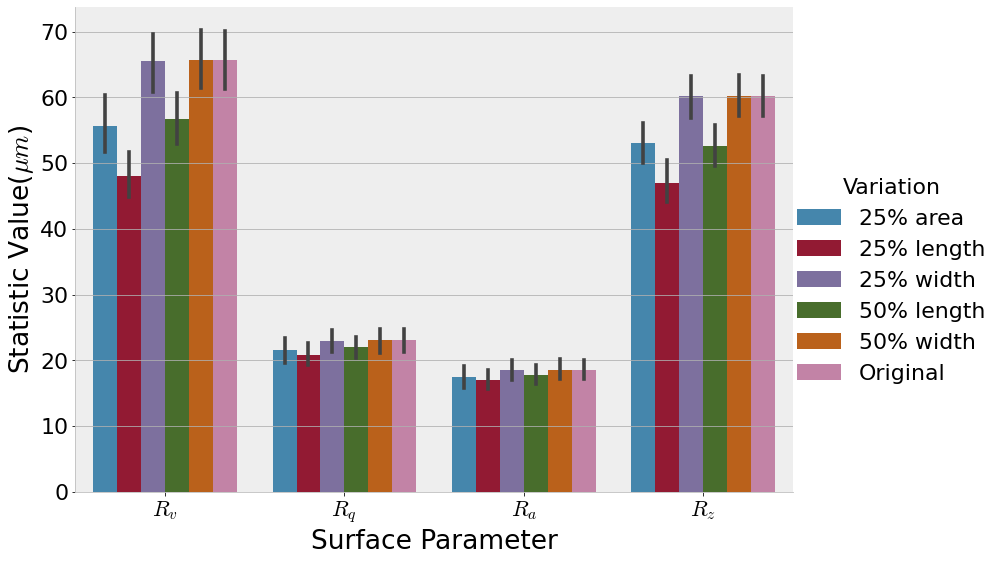

In [20]:
# sns.set_palette("deep")
d = data[data['Measure'] != 'r10_iso']
dic = {'rv': r"$R_v$", 'rq': r"$R_q$", 'ra': r"$R_a$", 'rz': r"$R_z$"}
d['Surface Parameter'] = data['Measure'].map(dic)
ax = sns.catplot(data=d, kind='bar',  height=8.27, aspect=11.7/8.27, 
                 x='Surface Parameter', y='Statistic Value($\mu m$)', hue='Variation')
# savefig('../data/paper/figures/global_measure_comparison.png', dpi=300)

# Experiment: Comparing repeated measures

In [8]:
%load_ext autoreload
%autoreload 2
%reset -f

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from imports import *
from additive.utility import dfe, get_file_info
from sh import wget
from numpy import genfromtxt

In [10]:
info_files = glob.glob("../data/experiment_03//*_2.info")
info_files = info_files + [x.replace("_2", "") for x in info_files]

In [11]:
def get_stats_from_file(data):
    if isinstance(data, str):
        data = joblib.load(data)['value']
    return data.statistics, data.circle_statistics#.describe()

In [12]:
with Pool(8) as p:
    all_stats_ = p.map(get_stats_from_file, info_files)

In [95]:
global_stats_ = [x for x, y in all_stats_]
circle_stats_ = [y for x, y in all_stats_]

In [96]:
global_stats = pd.concat([x.assign(file=dfe(f)[1]) for x, f in zip(global_stats_, info_files)])\
    .reset_index()#.drop('index', axis=1)#.rename(columns={"index": "measure"})
global_stats['repetition'] = global_stats['file'].str.contains("_2") * 1 + 1
global_stats['file'] = global_stats['file'].str.replace("_2", '')
global_stats

,index,rv,ra,rz,rq,r10_iso,file,repetition
0,0,180.668280,28.297204,18.416615,40.537096,NaN,V19_T1_Right(Top)_500X_3D,2
1,1,179.286918,29.452539,19.470803,41.059895,NaN,V19_T1_Right(Top)_500X_3D,2
2,2,176.691939,31.504457,21.499101,42.336516,NaN,V19_T1_Right(Top)_500X_3D,2
3,3,173.161809,34.531464,24.366313,44.567935,NaN,V19_T1_Right(Top)_500X_3D,2
4,4,169.000613,38.458735,27.918929,47.696514,NaN,V19_T1_Right(Top)_500X_3D,2
...,...,...,...,...,...,...,...,...
55684,7245,87.966996,16.938349,18.855455,22.201247,60.226305,V19_T2_Left(Bottom)_500X_3D,1
55685,7246,75.403560,13.912015,14.814021,18.700508,49.211100,V19_T2_Left(Bottom)_500X_3D,1
55686,7247,62.561338,11.055807,11.367236,15.344890,39.316375,V19_T2_Left(Bottom)_500X_3D,1
55687,7248,51.975379,8.899100,8.829132,12.696007,31.425529,V19_T2_Left(Bottom)_500X_3D,1


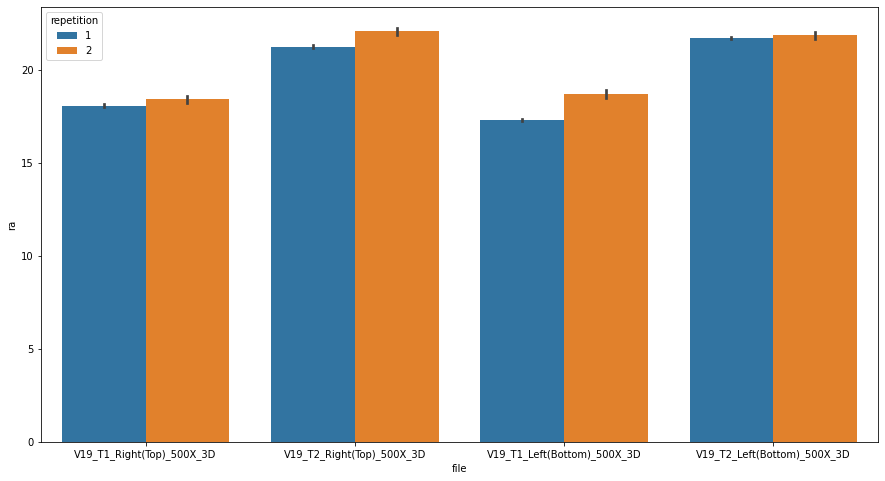

In [107]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15, 8))
#tt = t.stack().reset_index().rename(columns={'level_2': 'measure', 0: 'value'})
sns.barplot(data=global_stats, x='file', y='ra', hue='repetition')

In [106]:
from scipy.stats import ttest_ind
for col in ['rho', 'ra', 'rv', 'rz', 'rq']:
    if col not in global_stats.columns:
        continue
    for file in np.unique(global_stats['file']):
        cond1 = (global_stats['repetition'] == 1) & (global_stats['file'] == file)
        cond2 = (global_stats['repetition'] == 2) & (global_stats['file'] == file)
        ra = global_stats[col]
        pvalue = ttest_ind(ra[cond1], ra[cond2]).pvalue
        if pvalue > .05:
            print(file, col, pvalue)

V19_T2_Left(Bottom)_500X_3D ra 0.15426378822213835
V19_T2_Left(Bottom)_500X_3D rv 0.15046199388792791
V19_T2_Left(Bottom)_500X_3D rq 0.056542146837501715


In [32]:
s = np.array([2.330435, 2.33016])
1/s

array([0.42910444, 0.42915508])